In [1]:
import numpy as np
import matplotlib.pyplot as plt
import DataUtilities

# 1.1 - Utility Functions

In [2]:
def getSensors(measurementData, time, sensor_index, codeDict):
    """Gets all sensor readings for a given time step"""
    z_t = np.zeros(shape=(0,3))
    
    # Check index is within bounds
    if (sensor_index >= measurementData.shape[0]):
        return z_t, sensor_index
    
    # Keep incrementing index
    while(measurementData[sensor_index,0] - time < 0.005):
        z_code = measurementData[sensor_index,1]
        z_range = measurementData[sensor_index,2]
        z_bearing = measurementData[sensor_index,3]
        
        landmarkID = 0;
        if (z_code in codeDict):
            landmarkID = codeDict[z_code]
        else:
            continue
        
        if ((landmarkID > 5) and (landmarkID < 21)):
            z_new = [z_range, z_bearing, landmarkID]
            z_t = np.vstack([z_t, z_new])
        sensor_index += 1
        
        if (sensor_index >= measurementData.shape[0]):
            return z_t, sensor_index
        
    return z_t, sensor_index

# 1.2 - EKF-SLAM Class

In [3]:
class SLAM_EKF():
    def __init__(self):
        self._map = None
        self._state = None
        self._var = None
        self._alphas = None
        self._Q = None
        self._F = None
    
    @property
    def state(self):
        return self._state.T[0]
    
    def initState(self, x, y, theta):
        pose_states = np.array([[x], [y], [theta]])
        self._state = self._F.T @ pose_states
        
    def initStateCovariance(self, x_var, y_var, theta_var, landmark_var):
        num_landmarks = self._map.shape[0]
        self._var = np.zeros(shape=(2*num_landmarks+3,2*num_landmarks+3))
        # Robot pose covariances
        self._var[0][0] = x_var
        self._var[1][1] = y_var
        self._var[2][2] = theta_var
        # Landmark covariances
        for i in range(3, num_landmarks*2 + 3):
            self._var[i][i] = landmark_var
    
    def initInputCovariance(self, v_var, w_var):
        self._Q = np.diag([v_var, w_var])
        
    def initAlphas(self, alphas):
        self.alphas = alphas
    
    def initLandmarks(self, landmarks):
        self._map = landmarks
        # Sets up mapping matrix for state
        num_landmarks = landmarks.shape[0]
        self._F = np.hstack([np.eye(3), np.zeros(shape=(3,2*num_landmarks))])
        
    
    def correctAngle(self, angle):
        """Corrects an angle to be in [-pi, pi]"""
        while(angle < -np.pi):
            angle = angle + 2*np.pi
        while(angle > np.pi):
            angle = angle - 2*np.pi
        return angle
    
    def motionStep(self, v, w, dT):
        """Run the motion step to update pose and covariance with odometry"""
        # Used for calcs
        theta = self.state[2]
        C_t = np.cos(theta + 0.5*w*dT)
        S_t = np.sin(theta + 0.5*w*dT)
        num_landmarks = self._map.shape[0]

        # Calculate matrices
        g_t = np.array([[0, 0, -v*dT*S_t],
                        [0, 0, v*dT*C_t],
                        [0, 0, 0]])
        G_t = np.eye(2*num_landmarks + 3) + (self._F.T @ g_t @ self._F)

        M_t = np.array([[(self.alphas[0]*abs(v) + self.alphas[1]*abs(w))**2, 0],
                        [0, (self.alphas[2]*abs(v) + self.alphas[3]*abs(w))**2]])

        V_t = np.array([[C_t, -0.5*S_t],
                        [S_t, 0.5*C_t],
                        [0, 1]])
        
        # Update state
        d_state = np.array([[v*dT*C_t],
                            [v*dT*S_t],
                            [w*dT]])

        self._state = self._state + self._F.T @ d_state
        self._state[2,0] = self.correctAngle(self._state[2,0])
        
        # Update covariance
        R_t = V_t @ M_t @ V_t.T
        self._var = (G_t @ self._var @ G_t.T) + (self._F.T @ R_t @ self._F)
    
    def sensorStep(self, z_range, z_bearing, z_signature):
        """Run the sensor model for a single sensor hit"""
        # Used for calcs
        num_landmarks = self._map.shape[0]
        j = int(z_signature - 5) # Actual index (remove the 5 robot indices)
        
        # If new landmark, add it's position to the state
        if self._state[j*2 + 1][0] == 0:
            landmark_pos = np.array([[z_range*np.cos(z_bearing + self._state[2][0])],
                                     [z_range*np.sin(z_bearing + self._state[2][0])]])
            self._state[2*j+1][0] = self._state[0][0] + landmark_pos[0][0]
            self._state[2*j+2][0] = self._state[1][0] + landmark_pos[1][0]
        else: #Else, do the state and covariance updates
            # Predicted range and bearing calcs
            delta_x = self._state[2*j+1][0] - self._state[0][0]
            delta_y = self._state[2*j+2][0] - self._state[1][0]
            # Range
            q = delta_x**2 + delta_y**2
            r = np.sqrt(q) 
            # Predicted bearing
            beta = self.correctAngle(np.arctan2(delta_y, delta_x) - self._state[2][0])
            
            # Create z_t and z_exp vectors
            z_t = np.array([z_range, z_bearing])
            z_exp = [r, beta]

            # Calculate matrices
            h_t = np.array([[-delta_x/r, -delta_y/r, 0, delta_x/r, delta_y/r],
                            [delta_y/q, -delta_x/q, -1, -delta_y/q, delta_x/q]])

            F_1 = np.vstack([np.eye(3), np.zeros(shape=(2,3))])
            F_2 = np.vstack([np.zeros(shape=(3,2)), np.eye(2)])
            F_3 = np.zeros(shape=(5,2*j-2))
            F_4 = np.zeros(shape=(5,2*num_landmarks-2*j))
            F_xj = np.hstack([F_1, F_3, F_2, F_4])

            H_t = h_t @ F_xj

            K = self._var @ H_t.T @ np.linalg.inv(H_t @ self._var @ H_t.T + self._Q)

            # Update state
            self._state = self._state + np.expand_dims(K @ (z_t - z_exp), axis=1)
            self._state[2,0] = self.correctAngle(self._state[2,0])
            
            # Update covariance
            self._var = (np.eye(2*num_landmarks+3) - (K @ H_t)) @ self._var

# 1.3 - Load Data

In [4]:
# Robot data
truth_data = np.genfromtxt("Data/robot_groundtruth.csv", delimiter=",")
odom_data = np.genfromtxt("Data/robot_odometry.csv", delimiter=",")
meas_data = np.genfromtxt("Data/robot_measurement.csv", delimiter=",")

# Landmark data
landmark_data = DataUtilities.loadFile("Data\MRCLAM_Dataset1\Landmark_Groundtruth.dat")
bar_dict = DataUtilities.createBarcodeDict("Data\MRCLAM_Dataset1\Barcodes.dat")

# 1.4 - Run EKF-SLAM

In [5]:
dT = 0.02
start = 600

# Setup EKF
ekf = SLAM_EKF()
# Initialize landmark map
ekf.initLandmarks(landmark_data)
# Intialize initial state
ekf.initState(truth_data[start,1], truth_data[start,2], truth_data[start,3])
# Initialize covariance matrices and movement uncertainties
ekf.initStateCovariance(0.01, 0.01, 0.01, 10)
ekf.initInputCovariance(11.8, 0.18)
ekf.initAlphas([0.1, 0.01, 0.18, 0.08])


# Get sensor index up to a reasonable position
sensor_index = 0
while(meas_data[sensor_index][0] < odom_data[start][0] - 0.05):
    sensor_index += 1

# Run EKF
ekf_data = np.empty(shape=(0,4))
for i in range(start, odom_data.shape[0]):
    # Motion model
    time, v, w = odom_data[i,:]
    ekf.motionStep(v, w, dT)
    
    # Sensor model
    z_t, sensor_index = getSensors(meas_data, time, sensor_index, bar_dict)
    for j in range(len(z_t)):
        z_range = z_t[j,0]
        z_bearing = z_t[j,1]
        z_signature = z_t[j,2]
        ekf.sensorStep(z_range, z_bearing, z_signature)

    # Save EKF state
    curr_state = ekf.state
    ekf_data = np.vstack([ekf_data, [time, curr_state[0], curr_state[1], curr_state[2]]])
final_state = curr_state

# 1.5 - Plot Path

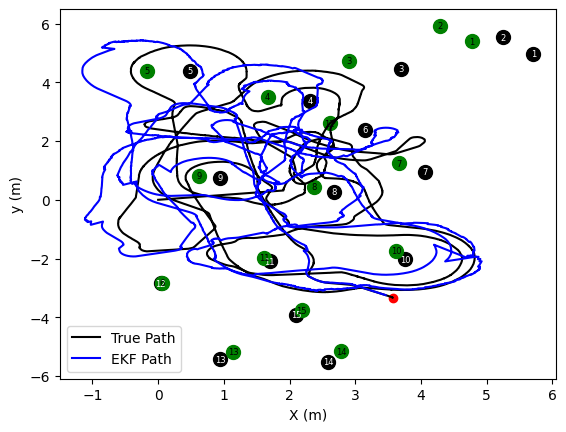

In [6]:
# plt.figure(figsize=(10,10))
# Plot true path
plt.plot(truth_data[:,1], truth_data[:,2], c='black', label="True Path")
# Plot EKF path
plt.plot(ekf_data[:,1], ekf_data[:,2], c="blue", label="EKF Path")
# Plot landmarks
landmark_pos = final_state[3:]
landmark_x = landmark_pos[::2]
landmark_y = landmark_pos[1::2]
plt.scatter(landmark_data[:,1], landmark_data[:,2], c='black', s=100)
for i, landmark in enumerate(landmark_data):
    plt.text(landmark[1], landmark[2], i+1, c="white", ha="center", va="center", fontsize=6)
plt.scatter(landmark_x, landmark_y, c='green', s=100)
for i in range(15):
    plt.text(landmark_x[i], landmark_y[i], i+1, c="black", ha="center", va="center", fontsize=6)
plt.scatter(truth_data[0,1], truth_data[0,2], c="red")
# Setup and plot
plt.xlabel("X (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

# 1.6 - Errors

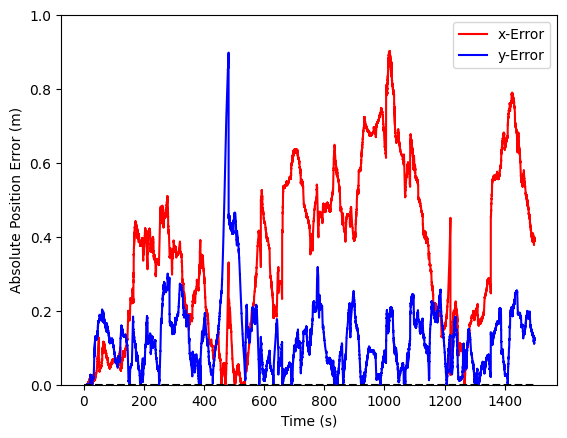

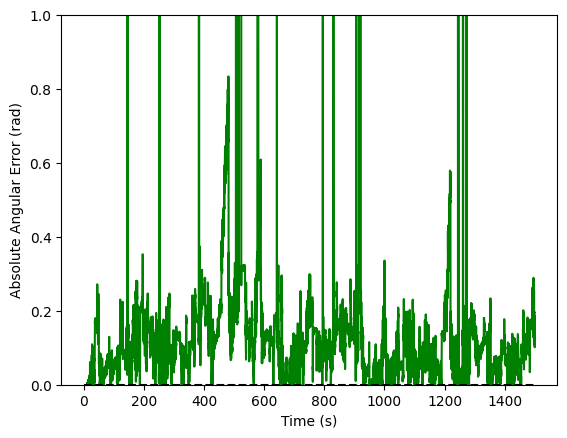

In [7]:
# Position error
plt.figure()
time = truth_data[start:,0]
x_error = abs(ekf_data[:,1] - truth_data[start:,1])
y_error = abs(ekf_data[:,2] - truth_data[start:,2])
offset = 1
plt.plot(time[:-offset], x_error[:-offset], c='red', label="x-Error")
plt.plot(time[:-offset], y_error[:-offset], c='blue', label="y-Error")
plt.hlines(0, truth_data[0,0], truth_data[-1,0], colors='black', ls="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Absolute Position Error (m)")
plt.ylim([0,1])
plt.show()

# Angular error
plt.figure()
time = truth_data[start:,0]
theta_error = abs(ekf_data[:,3] - truth_data[start:,3])
offset = 1
plt.plot(time[:-offset], theta_error[:-offset], c='green')
plt.hlines(0, truth_data[0,0], truth_data[-1,0], colors='black', ls="--")
plt.xlabel("Time (s)")
plt.ylabel("Absolute Angular Error (rad)")
plt.ylim([0,1])
plt.show()

# 1.7 - State Covariance Matrix

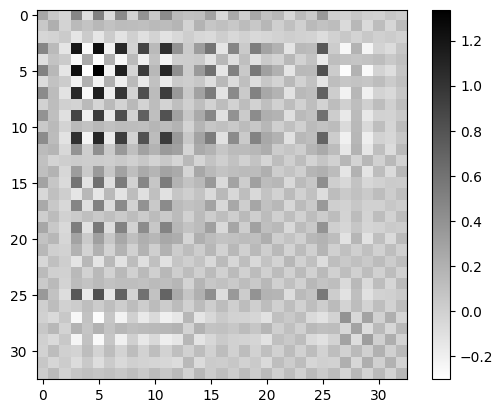

In [8]:
plt.imshow(ekf._var, cmap="gray_r")
plt.colorbar()